## Purpose of module

This module uses the technique described in 'Online short-term solar forecasting' by Bacher P, Madsen H & Nielsen HA (2009) to normalise the mean direct horizontal radiation by dividing by a clear sky model, created by smoothing the data in two dimensions; day of the year and hour of the day. 

## Import modules and load data

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import scipy
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from scipy.spatial import distance
from scipy import asarray as ar,exp
import numpy as np
import os
import pandas as pd
import patsy
import pylab as plb
import pytz
#import pyephem
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg

%matplotlib inline

In [2]:
PV = pd.read_csv('..//solar_data/PV_2017.csv',parse_dates=['date_time'],index_col='date_time')

# The timestamp in the input data is set to UTC but Pandas strips the time zone information when parsing.
# The following operation first creates 'time zone aware' timestamps, then localises it to Adelaide time.
PV.index = PV.index.tz_localize('UTC').tz_convert('Australia/Adelaide')

# Note, although this is the recommended approach, when resampling from 1-minute to 15-minute 
# frequency, there appears to be an error at the change to daylight saving where the local clock repeats an hour.

In [3]:
PV.columns

Index(['record_id', 'station_number', 'mean_global', 'min_global',
       'max_global', 'sd_global', 'uncert_mean_global', 'mean_direct',
       'min_direct', 'max_direct', 'sd_direct', 'uncert_mean_direct',
       'mean_diffuse', 'min_diffuse', 'max_diffuse', 'sd_diffuse',
       'uncert_mean_diffuse', 'mean_terr', 'min_terr', 'max_terr', 'sd_terr',
       'uncert_mean_terr', 'mean_dir_horiz', 'min_dir_horiz', 'max_dir_horiz',
       'sd_dir_horiz', 'uncert_dir_horiz', 'sunsh_sec_96', 'sunsh_sec_120',
       'sunsh_sec_144', 'zenith_dist'],
      dtype='object')

In [4]:
use_cols = ['mean_dir_horiz','mean_diffuse'] # Assuming the sum of these is the same as Global Horizontal Irradiance (GHI)
PV = PV[use_cols]

In [5]:
PV.head()

,mean_dir_horiz,mean_diffuse
date_time,,
2017-01-01 00:00:00+10:30,0.0,0.0
2017-01-01 00:01:00+10:30,0.0,0.0
2017-01-01 00:02:00+10:30,0.0,0.0
2017-01-01 00:03:00+10:30,0.0,0.0
2017-01-01 00:04:00+10:30,0.0,0.0


In [6]:
PV['GHI'] = PV.mean_dir_horiz + PV.mean_diffuse

In [7]:
# Confirm that the index is a time zone aware datetime object - return first and last objects
[PV.iloc[0].name,PV.iloc[-1].name]

[Timestamp('2017-01-01 00:00:00+1030', tz='Australia/Adelaide'),
 Timestamp('2017-12-31 23:59:00+1030', tz='Australia/Adelaide')]

### Resample from 1 minute frequency to 15 minute frequency to speed up calculation times

In [8]:
# Resample only columns derived from the DatetimeIndex
PV_15M = PV.resample('15T').mean()

In [9]:
PV_15M.head()

,mean_dir_horiz,mean_diffuse,GHI
date_time,,,
2017-01-01 00:00:00+10:30,0.0,0.0,0.0
2017-01-01 00:15:00+10:30,0.0,0.0,0.0
2017-01-01 00:30:00+10:30,0.0,0.0,0.0
2017-01-01 00:45:00+10:30,0.0,0.0,0.0
2017-01-01 01:00:00+10:30,0.0,0.0,0.0


## Deal with missing data

Count missing values

In [10]:
np.isnan(PV_15M).sum()

mean_dir_horiz    879
mean_diffuse      854
GHI               884
dtype: int64

In [11]:
PV_15M[np.isnan(PV_15M.GHI)].head()

,mean_dir_horiz,mean_diffuse,GHI
date_time,,,
2017-01-30 00:15:00+10:30,NaN,NaN,NaN
2017-01-30 00:30:00+10:30,NaN,NaN,NaN
2017-01-30 00:45:00+10:30,NaN,NaN,NaN
2017-01-30 01:00:00+10:30,NaN,NaN,NaN
2017-01-30 01:15:00+10:30,NaN,NaN,NaN


How should we deal with missing data here?  The data is being used to fit a regression plane.  

* Setting missing values to zero would distort the regression coefficients.
* Imputing missing values require a regression plane (chicken and egg problem).
* Replacing with the mean/median would also distort the regression coefficients (reduce variance).
* Deleting missing values means we can no longer neatly pack the data into an $x$ (day of year) by $y$ (time of day) array to calculate the objective function.
* Can we just leave missing values in for the time being? After packing the data into an $x$ by $y$ array, $z$ (actual solar power at the corresponding value of $x$ and $y$) will have missing data at some points, but $\hat z$ will not. Our objective/loss function then ignore those points on the $x$ by $y$ grid where there are missing values for $z$.

## Create new variables for analysis

Add time of day (in minutes from midnight at the start of each day):

In [12]:
PV_15M['time_of_day'] = PV_15M.index.map(lambda x: (
    x.combine(x.date(),x.time()) - x.combine(x.date(),dt.time(0,0))).seconds / 60 + 1)

Add day of year beginning 1 January:

In [13]:
first_day_of_year = dt.date(2017,1,1)
PV_15M['day_of_year'] = PV_15M.index.map(lambda x: (x.date() - first_day_of_year).days + 1)

Bacher, Madsen and Nielsen recommend fitting $z$ (clear sky solar power) to the $q^{th}$ quantile of a normal distribution in two dimensions to the data ($x$ = day of year and $y$ = time of day) to create a clear sky model. The normal distribution is centred around zero, hence we have done the same to our regressors, as follows.

Let each (solar) year be delimited by winter solstices, so the summer solstice falls in the middle of each year. Within each year, define `summer_solstice_delta` as the distance, in days, from the summer solstice.

In [14]:
winter_solstice = (6,21) # 21 June
summer_solstice = (12,22) # 22 December

In [15]:
def summer_solstice_delta(qdate):
    if qdate < dt.date(qdate.year,*winter_solstice): # Is date in last solar year?
        return (dt.date(qdate.year-1,*summer_solstice) - qdate).days # If so, return delta from last summer solstice
    else:
        return (dt.date(qdate.year,*summer_solstice) - qdate).days # Otherwise return delta from this summer solstice

PV_15M['summer_solstice_delta'] = PV_15M.index.map(lambda x: summer_solstice_delta(x.date()))

Similarly, define `midday_delta` as the distance, in minutes, from midday each day.

In [16]:
def midday_delta(time_of_day):
    return time_of_day - 12*60-1

PV_15M['midday_delta'] = midday_delta(PV_15M.time_of_day)

In [17]:
PV_15M.head()

,mean_dir_horiz,mean_diffuse,GHI,time_of_day,day_of_year,summer_solstice_delta,midday_delta
date_time,,,,,,,
2017-01-01 00:00:00+10:30,0.0,0.0,0.0,1.0,1,-10,-720.0
2017-01-01 00:15:00+10:30,0.0,0.0,0.0,16.0,1,-10,-705.0
2017-01-01 00:30:00+10:30,0.0,0.0,0.0,31.0,1,-10,-690.0
2017-01-01 00:45:00+10:30,0.0,0.0,0.0,46.0,1,-10,-675.0
2017-01-01 01:00:00+10:30,0.0,0.0,0.0,61.0,1,-10,-660.0


In [18]:
# Check missing values
np.isnan(PV_15M).sum()

mean_dir_horiz           879
mean_diffuse             854
GHI                      884
time_of_day                0
day_of_year                0
summer_solstice_delta      0
midday_delta               0
dtype: int64

### Visualise dataset

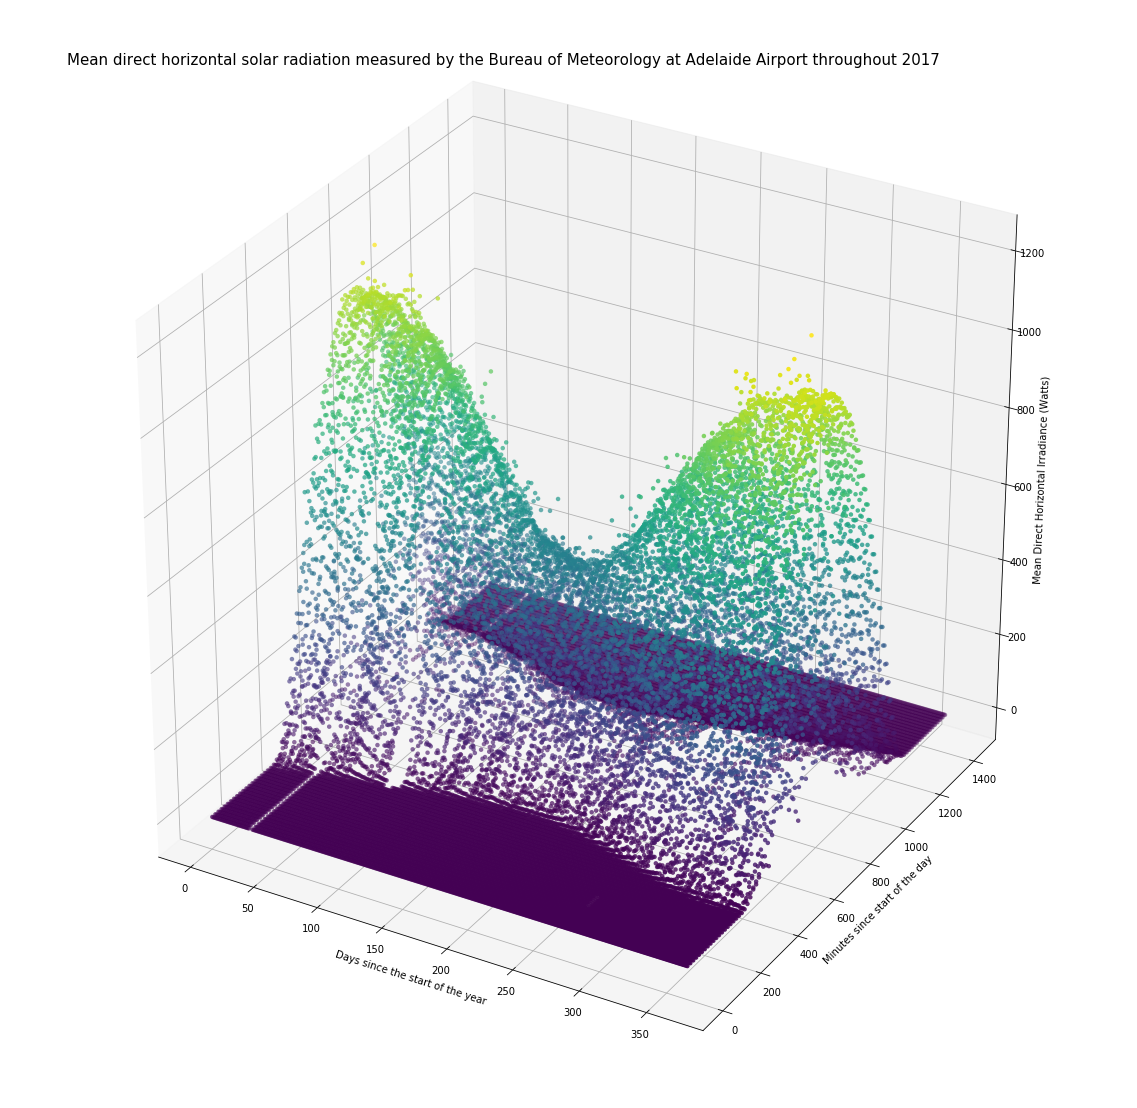

In [19]:
# Plot distribution of solar output by minute of the day and day of the year
fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')
ax.scatter(PV_15M.day_of_year, PV_15M.time_of_day, PV_15M.GHI, 
                c=PV_15M.GHI, linewidth=0.005)
ax.text2D(0.05, 0.95,
          'Mean direct horizontal solar radiation measured by the Bureau of Meteorology at Adelaide Airport throughout 2017',
          transform=ax.transAxes, fontsize=15)
ax.set_xlabel('Days since the start of the year')
ax.set_ylabel('Minutes since start of the day')
ax.set_zlabel('Mean Direct Horizontal Irradiance (Watts)')
plt.show()

__Observations__

* There is at least a day's missing data in late January.
* Some points sit well above the surface, likely due to the effect described by Luigi Cirocco and John Boland where reflection and magnification by cloud creates solar power above the 'clear sky solar power'.
* Otherwise, the data distribution is as expected.

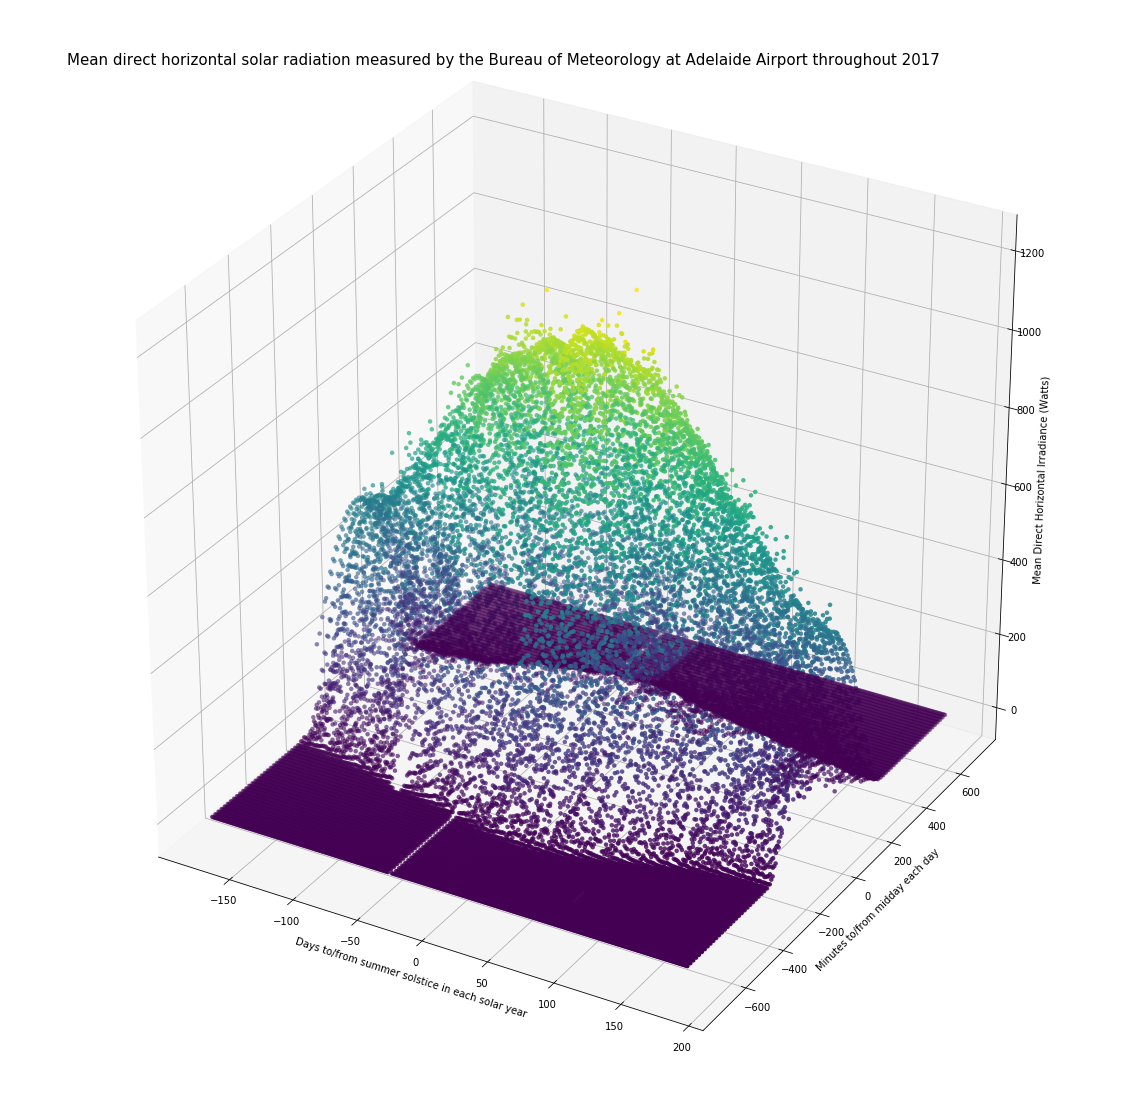

In [20]:
# Plot distribution of solar output by minute of the day and day of the year
fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')
ax.scatter(PV_15M.summer_solstice_delta, PV_15M.midday_delta, PV_15M.GHI, 
                c=PV_15M.GHI, linewidth=0.005)
ax.text2D(0.05, 0.95,
          'Mean direct horizontal solar radiation measured by the Bureau of Meteorology at Adelaide Airport throughout 2017',
          transform=ax.transAxes, fontsize=15)
ax.set_xlabel('Days to/from summer solstice in each solar year')
ax.set_ylabel('Minutes to/from midday each day')
ax.set_zlabel('Mean Direct Horizontal Irradiance (Watts)')
plt.show()

__Observations:__

* Maximum solar power appears to consistently peak later than midday. Should we change the variable to reflect distance from the peak?
* Using a normal distribution to model changes in solar power by the day of the year, the tails appear to approach approximately 450 watts at the winter solstices, rather than zero (as might occur in the upper northern hemisphere). Does this make the normal distribution a poor fit to our data? 

## Calculate 'clear sky' prediction of solar radiation at each minute of each day

Appendix A of 'Online short-term solar power forecasting' by Bache, Madsen & Nielsen, published in Solar Energy, Volume 83 (2009), pp.1772-1783, describes a method for calculating estimated clear sky solar power $\hat{p}_{t}^{cs}$ given a solar power time series $p_t$, $t=1$,...,$N$, found as the $q$ quantile of ${ {f}_{P} }_{t}$, which is the probability distribution function of $P_t$.  This should be a smooth function intersecting the maximums of the actual values $p_i$ on the diagram above.

The problem is reduced to estimating $\hat{p}_{t}^{cs}$ as a local constant for each $(x_t,y_t)$, where $x$ is the days since the start of the year and $y$ is the number of minutes since the start of the day.  

The loss function $\rho(q,\epsilon_i$) is:

\begin{equation*}
\rho(q,\epsilon_i) =
\begin{cases}
    q\epsilon_i ,\quad \quad \quad \epsilon_i >= 0,  \\
    (1 - q)\epsilon_i ,\quad \epsilon_i < 0, \\
\end{cases}
\end{equation*}

where:

\begin{equation*}
\epsilon_i = p_i - \hat{p}_{t}^{cs}
\end{equation*}

The fitting is done by:

\begin{equation*}
\underset{\hat{p}_{t}^{cs}}{\operatorname{arg min}} = \sum_{i=1}^N k(x_t,y_t,x_i,y_i)\cdot \rho(q,\epsilon_i),
\end{equation*}

where:

\begin{equation*}
k(x_t,y_t,x_i,y_i) = \frac{w(x_t,x_i,h_x)\cdot w(y_t,y_i,h_y)}{\sum_{i=1}^N w(x_t,x_i,h_x)\cdot w(y_t,y_i,h_y)}
\end{equation*}

is the two-dimensional multiplicative kernel function which weights the observations locally to $(x_t,y_t)$, following Hastie & Tibshirani's 'Varying-Coefficient Models' published in the Journal of the Royal Statistical Society. Series B (Methodological), Vol. 55, No. 4 (1993), pp. 757-796.

In each dimension a Gaussian kernel is used

\begin{equation*}
w(x_t,x_i,h_x) = f_{std}\left(\frac{\left|{x_t-x_i}\right|}{h_x}\right),
\end{equation*}

where $f_{std}$ is the standard normal probability density function. A similar kernel function is used in the $y$ dimension and the final two-dimensional kernel is found by multiplying the two kernels.

### Pack the (X) time of day and (Y) days since winter solstice variables into a single 3D array

In [21]:
X = PV_15M.midday_delta.values.reshape(365,96)
Y = PV_15M.summer_solstice_delta.values.reshape(365,96)
Z = PV_15M.GHI.values.reshape(365,96)

dim = (365,96)
pos = np.empty(dim + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

### Fit the normal distribution in 1 dimension

In [22]:
# One sunny day's actual data
y = Z[151]

In [23]:
x = ar(range(len(y)))

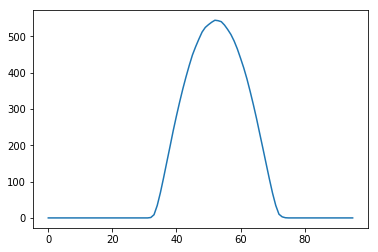

In [24]:
plt.plot(y);

In [25]:
mean = sum(x*y)/sum(y)
sigma = np.sqrt(sum(y*(x-mean)**2)/sum(y))

In [26]:
mean

52.43623782118453

In [27]:
def gaus(x,a,x0,sigma):
    return a* np.exp(-(x-x0)**2/(2*sigma**2))

In [28]:
popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])

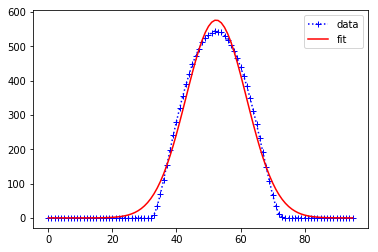

In [29]:
plt.plot(x, y, 'b+:', label='data')
plt.plot(x, gaus(x, *popt), 'r-', label='fit')
plt.legend()
plt.show;

### Example of bivariate normal distribution from [here](https://scipython.com/blog/visualizing-the-bivariate-gaussian-distribution/)

In [30]:
# Our 2-dimensional distribution will be over variables X and Y
N = 60
X_example = np.linspace(-600, 600, N)
Y_example = np.linspace(-160, 160, N)
X_example, Y_example = np.meshgrid(X_example, Y_example)

In [31]:
# Mean vector and covariance matrix
mu = np.array([0.4, .7])
Sigma = np.array([[ 6000. , -.5], [-.5, 18000.0]])

In [32]:
# Pack X and Y into a single 3-dimensional array
pos_example = np.empty(X_example.shape + (2,))
pos_example[:, :, 0] = X_example
pos_example[:, :, 1] = Y_example

In [33]:
from scipy.stats import multivariate_normal
F = multivariate_normal(mu, Sigma)
Z_hat_example = F.pdf(pos_example)

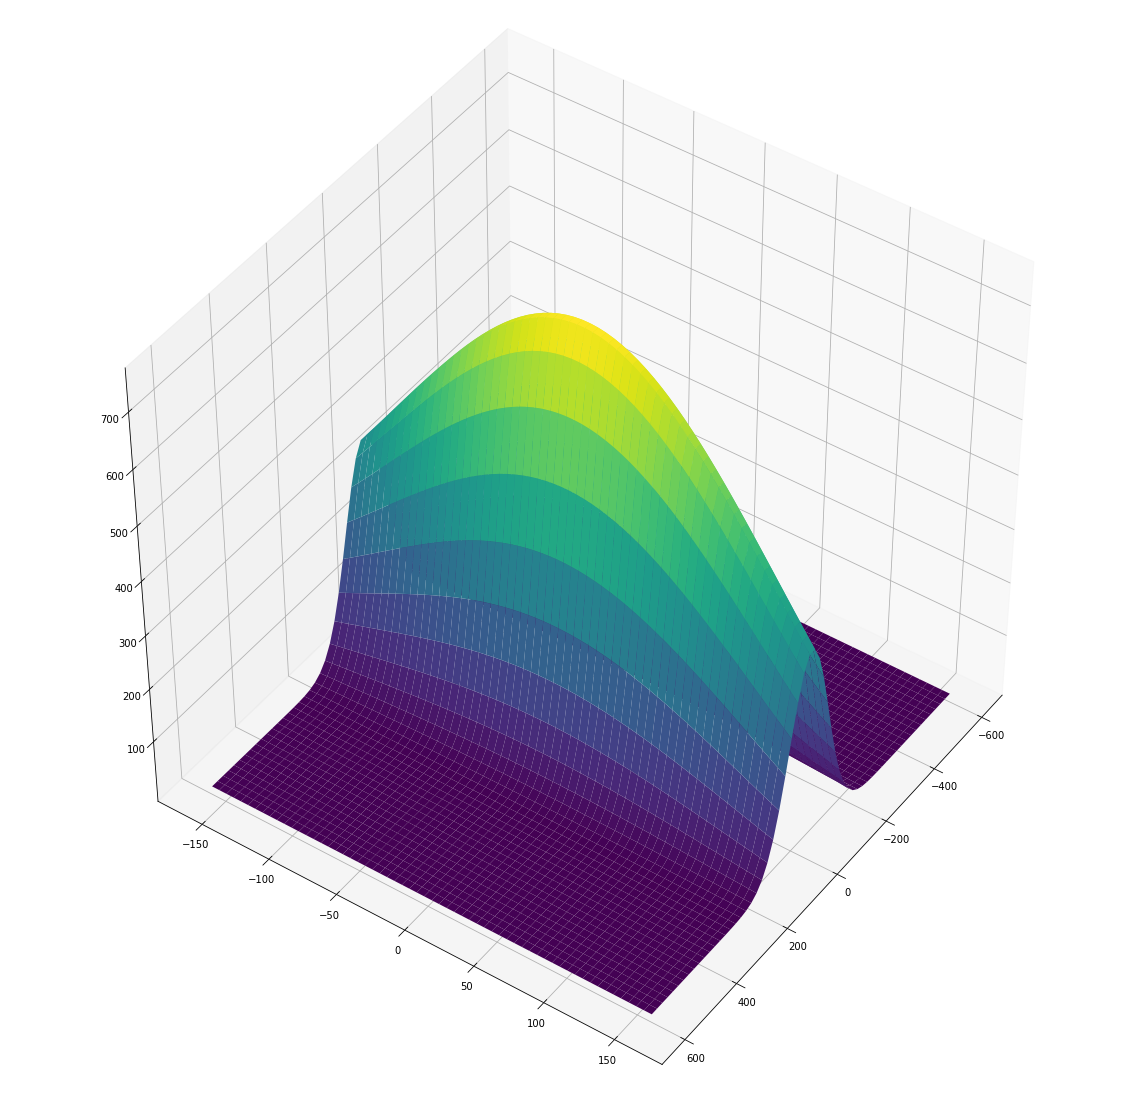

In [34]:
# Create a surface plot.
fig = plt.figure(figsize=(20,20))
ax = fig.gca(projection='3d')
ax.plot_surface(X_example, Y_example, Z_hat_example*5e7, 
                rstride=1, cstride=1, linewidth=1, antialiased=True,
                cmap=cm.viridis)
ax.view_init(45,35)
plt.show()

In [35]:
X.shape

(365, 96)

### Now expand to fit normal distribution in two dimensions

### Attempt to use scipy.optimize.minimise to vary mu and Sigma parameters to minimise MAE between observations and bivariate Gaussian regression plane (think about quantile regression component next...)

In [36]:
PV_15M.summer_solstice_delta.nunique()

365

In [37]:
PV_15M.midday_delta.nunique()

96

In [38]:
params = [0.4, 0.7, 6000., -.5, -.5, 18000., 5e7]

In [39]:
def create_Z_hat(params):
    mu_X = params[0]
    mu_Y = params[1]
    mu = np.array([mu_X, mu_Y])
    
    sigma_1 = params[2]
    sigma_2 = params[3]
    sigma_3 = params[4]
    sigma_4 = params[5]
    
    scale_up = params[6]
    
    Sigma = np.array([[sigma_1 , sigma_2], [sigma_3,  sigma_4]])
    model = multivariate_normal(mu, Sigma)      
    Z_hat = model.pdf(pos) # Probability distribution function
    Z_hat = Z_hat * scale_up # Scale up to have the same sum as Z
    return Z_hat

In [40]:
Z_hat = create_Z_hat(params)

In [41]:
def objective(params):
    return np.nansum(np.absolute(Z_hat - Z))

In [42]:
pos.shape

(365, 96, 2)

In [43]:
objective(params)

4640685.750451522

In [44]:
def isPSD(params, tol=1e-8):
  E,V = scipy.linalg.eigvalsh(np.matrix(params[2:6]).reshape(2,2))
  return np.all(E > -tol)

In [45]:
def constraint(params):
    return isPSD(params) + 1

In [46]:
cons = {'type':'eq', 'fun': constraint}

In [47]:
isPSD(params)

True

In [48]:
solution = minimize(fun=objective,x0=params)

In [49]:
help(minimize)

Help on function minimize in module scipy.optimize._minimize:

minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
    Minimization of scalar function of one or more variables.
    
    In general, the optimization problems are of the form::
    
        minimize f(x) subject to
    
        g_i(x) >= 0,  i = 1,...,m
        h_j(x)  = 0,  j = 1,...,p
    
    where x is a vector of one or more variables.
    ``g_i(x)`` are the inequality constraints.
    ``h_j(x)`` are the equality constrains.
    
    Optionally, the lower and upper bounds for each element in x can also be
    specified using the `bounds` argument.
    
    Parameters
    ----------
    fun : callable
        The objective function to be minimized. Must be in the form
        ``f(x, *args)``. The optimizing argument, ``x``, is a 1-D array
        of points, and ``args`` is a tuple of any additional fixed parameters
        needed 

In [50]:
solution

      fun: 4640685.750451522
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1]])
      jac: array([0., 0., 0., 0., 0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 9
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([ 4.0e-01,  7.0e-01,  6.0e+03, -5.0e-01, -5.0e-01,  1.8e+04,
        5.0e+07])

In [51]:
solution

      fun: 4640685.750451522
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1]])
      jac: array([0., 0., 0., 0., 0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 9
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([ 4.0e-01,  7.0e-01,  6.0e+03, -5.0e-01, -5.0e-01,  1.8e+04,
        5.0e+07])

### Overlay regression plane with observed data

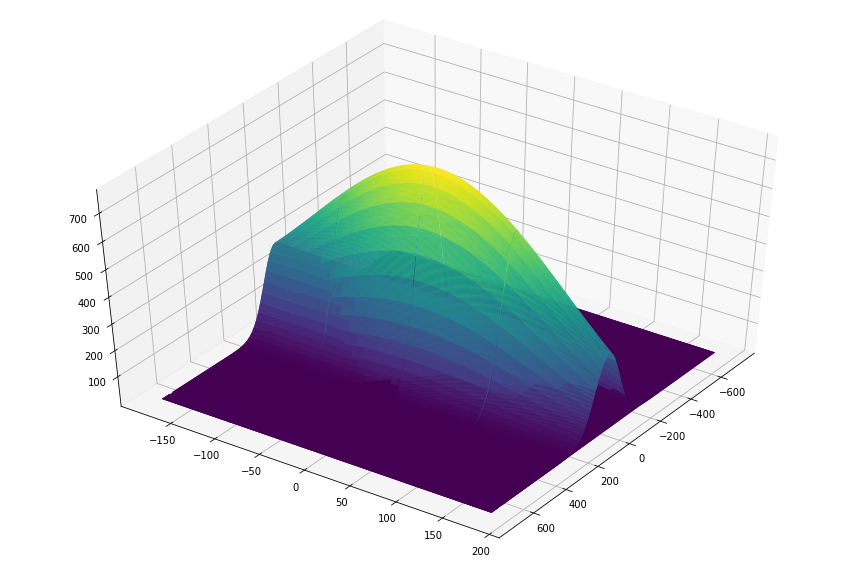

In [52]:
# Create a surface plot.
fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z_hat, rstride=1, cstride=1, linewidth=1, antialiased=True,
                cmap=cm.viridis)
ax.view_init(45,35)
plt.show()

### Build quantile regression model predicting GHI from the number of minutes after the start of the day - based on __[the examples in the documentation](https://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html)__

In [53]:
quantiles = np.arange(0.6,1,.025)

def fit_model(q):
    mod = smf.quantreg('GHI ~ midday_delta + summer_solstice_delta', PV_15M)
    res = mod.fit(q=q, kernel='gau')
    return [q, res.params['Intercept'], res.params['midday_delta']] + \
           res.conf_int().loc['midday_delta'].tolist()

models = [fit_model(y) for y in quantiles]
models = pd.DataFrame(models, columns=['q','a','b','lb','ub'])


In [54]:
models = pd.DataFrame(models, columns=['q','a','b','lb','ub'])
models

,q,a,b,lb,ub
0,0.600,95.169031,0.126657,0.122826,0.130488
1,0.625,130.891196,0.152875,0.147933,0.157816
2,0.650,169.151964,0.176046,0.168689,0.183403
3,0.675,211.179430,0.196772,0.185578,0.207966
4,0.700,253.185962,0.216763,0.203112,0.230415
5,0.725,301.240740,0.235275,0.220947,0.249604
6,0.750,348.734302,0.254434,0.240724,0.268144
7,0.775,399.178864,0.271937,0.259014,0.284861
8,0.800,449.664132,0.294566,0.282630,0.306501
9,0.825,502.032541,0.311313,0.300386,0.322239


In [55]:
mod = smf.quantreg('GHI ~ midday_delta + summer_solstice_delta', PV_15M)

In [56]:
res = mod.fit(q=0.85, kernel='gau')

In [57]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    GHI   Pseudo R-squared:             0.006739
Model:                       QuantReg   Bandwidth:                       36.49
Method:                 Least Squares   Sparsity:                        2404.
Date:                Mon, 27 Aug 2018   No. Observations:                34156
Time:                        15:35:57   Df Residuals:                    34153
                                        Df Model:                            2
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               557.0119      4.647    119.872      0.000     547.904     566.120
midday_delta              0.3546      0.006     64.016      0.000       0.344       0.365
summer_solstice_delta    -0.0912      0.032     -2.859      0.004      -0.154      -0.029
=========================================================================================
"""

This does not appear to be fitting a normal distribution to the data.

In [58]:
from scipy.optimize import curve_fit

In [59]:
curve_fit.

SyntaxError: invalid syntax (<ipython-input-59-e30ad0acc542>, line 1)

The headings for the output parameters are based on a linear regression. What do these represent and how can they be translated back into a normal distribution?